In [1]:
import requests
import pandas as  pd
from  bs4 import BeautifulSoup
import sqlite3
import matplotlib.pyplot as plt
import numpy as np


def scrape_page(): #Fuction to scrape data
    URL="https://www.worldometers.info/co2-emissions/"
    
    html_page=requests.get(URL).text #Gets the website and displays as text
    soup=BeautifulSoup(html_page,"html.parser") #Makes it easy to read
    get_table=soup.find("table",class_="datatable") #finds table with class: "database"
    get_table_data=get_table.tbody.find_all("tr") #finds rows-the data I need are in rows
    
    
    dic={}
    for i in range(len(get_table_data)): #This loop helps to fecth the  data in rows 
        key=get_table_data[i].find_all("a",href=True)[0].string #Gets the countries | Index 0
    
        values=[j.string for j in get_table_data[i].find_all(["td","a"])] #This code gets the data in the table-it gets it from td and a tags
        dic[key]=values #stores in dictionary
    
    column_names=["CO2 emissions(tons, 2022)","Year 1 Change","Population (2022)","Per Capital","Share of the world"]
    
    df=pd.DataFrame(dic).iloc[3:,:].T
    df.index.name="Country"
    df.columns=column_names
    
    df.to_csv("CO2_emissions.csv")  #storing the scraped data as csv

#scrape_page()
    
#Reading the csv file
df1=pd.read_csv('CO2_emissions.csv')
df1.columns

Index(['Country', 'CO2 emissions(tons, 2022)', 'Year 1 Change',
       'Population (2022)', 'Per Capital', 'Share of the world'],
      dtype='object')

In [2]:


connection=sqlite3.connect('emissions.db')

df1.to_sql('CO2_emissions',connection,if_exists="replace",index=False) #uploading to sql database

# query_result = pd.read_sql("SELECT * FROM CO2_emissions;", connection) #Alows me to read the database
# # print(query_result) Prints out the table in the database



cursor=connection.cursor() #Initiated this to  enable me to interact with the database


#Querying sql  to update to 0 when NULL---applied this to one column because I don't have NULLs
cursor.execute("""
    UPDATE CO2_emissions
    SET "CO2 emissions(tons, 2022)" = 0
    WHERE "CO2 emissions(tons, 2022)" IS NULL;
""")

connection.commit() ##saves the changes

query_result = pd.read_sql("SELECT * FROM CO2_emissions;", connection) #Alows me to read the database
# print(query_result) Prints out the table in the database
connection.close()


query_result.to_csv("CO2_emissions_after_sql.csv",index=False) #Saves the database to csv and avoids additional index column



##Reading cleaned csv file
df2=pd.read_csv("CO2_emissions_after_sql.csv") ## df2 now has the data


In [3]:
#DATA ANALYSIS

                            ##Coverting columns to numeric to perform analysis
df2["CO2 emissions(tons, 2022)"] = df2["CO2 emissions(tons, 2022)"].str.replace(",", "").astype(float) #This coverts the CO2 emissions column to float so I  can find the mean. 
df2["Population (2022)"]=df2["Population (2022)"].str.replace(",","").astype(float) #Population  column to numeric
df2["Year 1 Change"] = (
    df2["Year 1 Change"]
    .str.replace("−", "-")   # replacing weird minus with normal one
    .str.replace("%", "")    # removing the % sign
    .astype(float)
)

co2_mean=df2["CO2 emissions(tons, 2022)"].mean() #Mean
co2_std=df2["CO2 emissions(tons, 2022)"].std()  #Standard Deviation
co2_var=df2["CO2 emissions(tons, 2022)"].var()  #Variance 

print(f""" For CO2 emissions(tons, 2022):
            mean={co2_mean}
            Standard Deviation={co2_std}
            Variance={co2_var}
""")

per_capital_mean=df2["Per Capital"].mean() #Mean
per_capital_std=df2["Per Capital"].std()    #Standard Deviation
per_capital_var=df2["Per Capital"].var() #Variance 

print(f""" For Per Capital:
            mean={per_capital_mean}
            Standard Deviaion={per_capital_std}
            Variance={per_capital_var}
""")



 For CO2 emissions(tons, 2022):
            mean=181228174.90291262
            Standard Deviation=973455949.8707097
            Variance=9.476164863386857e+17

 For Per Capital:
            mean=4.666747572815534
            Standard Deviaion=7.258890233286112
            Variance=52.69148741889651



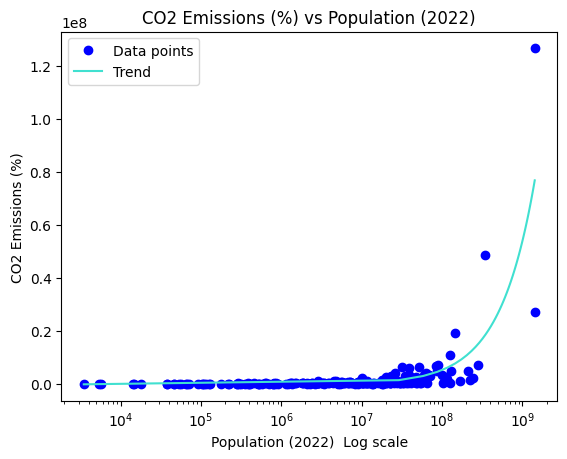

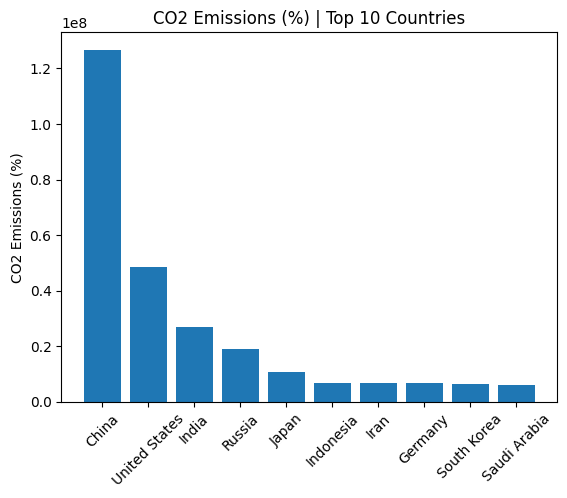

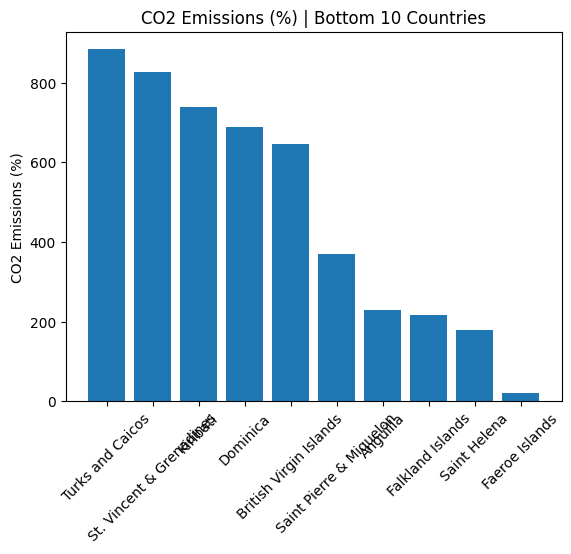

In [5]:
##Matplotlib  Visualization

df2["per_co2_emissions"]=df2["CO2 emissions(tons, 2022)"]/100 ##Finding the percentage of 'C02 emissions' column and creating a new column

m, b = np.polyfit(df2['Population (2022)'], df2['per_co2_emissions'], deg=1) #Adding line to show trend

#Setting the limits for the line
amin = df2['Population (2022)'].min() 
amax = df2['Population (2022)'].max()
x = np.linspace(amin, amax, 50)


plt.plot(df2['Population (2022)'], df2['per_co2_emissions'], linestyle='None', marker='o', color='blue', label='Data points') #Ploting my data


plt.plot(x, m*x + b, color='turquoise', linestyle='-', label="Trend")#Plotting the line

plt.xscale('log')#Converting population to logarithmic values


plt.xlabel('Population (2022)  Log scale')
plt.ylabel('CO2 Emissions (%)')
plt.title('CO2 Emissions (%) vs Population (2022)')


plt.legend()


plt.show() #This graph displays the relationship between population and CO2 emissions. There is a positive correlation
               
               

df3=df2.head(10)
x=df3["Country"]
y=df3["per_co2_emissions"]


plt.ylabel('CO2 Emissions (%)')
plt.title('CO2 Emissions (%) | Top 10 Countries') 
plt.xticks(rotation=45)
plt.bar(x,y)  #Bar chart to show top 10 countries
plt.show()


df4=df2.tail(10)
y=df4["per_co2_emissions"]
x=df4["Country"]

plt.ylabel('CO2 Emissions (%)')
plt.title('CO2 Emissions (%) | Bottom 10 Countries')
plt.xticks(rotation=45)
plt.bar(x,y) #Bar chart to show bottom 10 countries
plt.show()